In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, uniform

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier


## Análisis exploratorio

In [2]:
data = pd.read_csv("archive/train_u6lujuX_CVtuZ9i.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [4]:
data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [5]:
# Identificar valores faltantes en cada columna
missing_values = data.isnull().sum()

# Mostrar las columnas con valores faltantes y su cantidad
missing_values[missing_values > 0]


Gender              13
Married              3
Dependents          15
Self_Employed       32
LoanAmount          22
Loan_Amount_Term    14
Credit_History      50
dtype: int64

In [6]:
# Rellenar valores faltantes en variables categóricas con la moda
categorical_columns = ['Gender', 'Married', 'Dependents', 'Self_Employed']
for column in categorical_columns:
    data[column].fillna(data[column].mode()[0], inplace=True)

# Rellenar valores faltantes en variables numéricas con la mediana
numerical_columns = ['LoanAmount', 'Loan_Amount_Term', 'Credit_History']
for column in numerical_columns:
    data[column].fillna(data[column].median(), inplace=True)

# Verificar si aún quedan valores faltantes
remaining_missing_values = data.isnull().sum().sum()

remaining_missing_values


0

In [7]:
# Codificación de variables categóricas excepto 'Loan_Status' usando pd.get_dummies
data_encoded = pd.get_dummies(data, columns=['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area'], drop_first=True)

# Mostrar las primeras filas del DataFrame para revisar las nuevas columnas codificadas
data_encoded.head()

,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,LP001002,5849,0.0,128.0,360.0,1.0,Y,True,False,False,False,False,False,False,False,True
1,LP001003,4583,1508.0,128.0,360.0,1.0,N,True,True,True,False,False,False,False,False,False
2,LP001005,3000,0.0,66.0,360.0,1.0,Y,True,True,False,False,False,False,True,False,True
3,LP001006,2583,2358.0,120.0,360.0,1.0,Y,True,True,False,False,False,True,False,False,True
4,LP001008,6000,0.0,141.0,360.0,1.0,Y,True,False,False,False,False,False,False,False,True


## Ingeniería de características.

In [8]:
# Ingeniería de características: Creación de nuevas características
data_encoded['TotalIncome'] = data_encoded['ApplicantIncome'] + data_encoded['CoapplicantIncome']
data_encoded['LoanIncomeRatio'] = data_encoded['LoanAmount'] / data_encoded['TotalIncome']

# Creación de una característica de interacción entre TotalIncome y LoanAmount
data_encoded['IncomeLoanInteraction'] = data_encoded['TotalIncome'] * data_encoded['LoanAmount']

# Creación de características polinomiales para LoanAmount (al cuadrado y al cubo)
data_encoded['LoanAmount_squared'] = data_encoded['LoanAmount'] ** 2
data_encoded['LoanAmount_cubed'] = data_encoded['LoanAmount'] ** 3

# Seleccionar características numéricas para normalización (excluyendo las que ya están en escala binaria)
features_to_normalize = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'TotalIncome', 'LoanIncomeRatio']

scaler = MinMaxScaler()
data_encoded[features_to_normalize] = scaler.fit_transform(data_encoded[features_to_normalize])

# Mostrar las primeras filas para revisar los cambios realizados
data_encoded.head()


,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Male,Married_Yes,Dependents_1,...,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,TotalIncome,LoanIncomeRatio,IncomeLoanInteraction,LoanAmount_squared,LoanAmount_cubed
0,LP001002,0.070489,0.000000,0.172214,0.74359,1.0,Y,True,False,False,...,False,False,False,False,True,0.055394,0.241445,748672.0,16384.0,2097152.0
1,LP001003,0.054830,0.036192,0.172214,0.74359,1.0,N,True,True,True,...,False,False,False,False,False,0.058435,0.230602,779648.0,16384.0,2097152.0
2,LP001005,0.035250,0.000000,0.082489,0.74359,1.0,Y,True,True,False,...,False,False,True,False,True,0.019583,0.242891,198000.0,4356.0,287496.0
3,LP001006,0.030093,0.056592,0.160637,0.74359,1.0,Y,True,True,False,...,False,True,False,False,True,0.043980,0.271406,592920.0,14400.0,1728000.0
4,LP001008,0.072356,0.000000,0.191027,0.74359,1.0,Y,True,False,False,...,False,False,False,False,True,0.057292,0.261596,846000.0,19881.0,2803221.0


## Gráficas

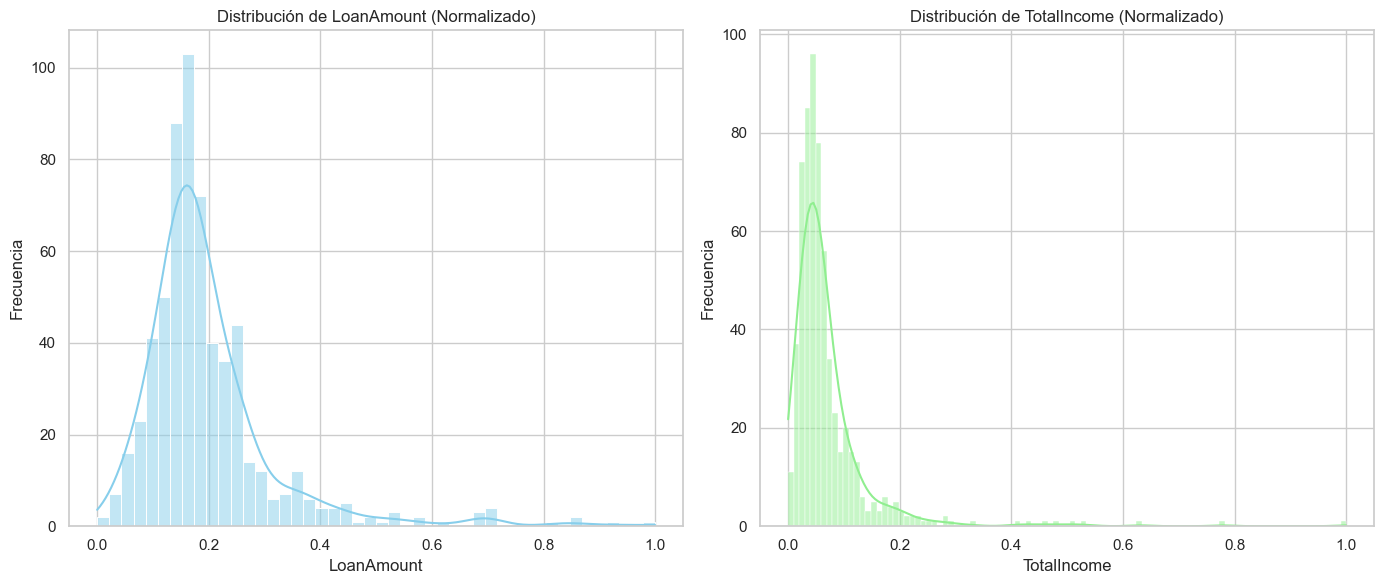

In [9]:
# Configurar estilo de gráficos
sns.set(style="whitegrid")

# Crear figura y ejes para los gráficos
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico para la distribución de LoanAmount
sns.histplot(data_encoded['LoanAmount'], kde=True, ax=ax[0], color='skyblue')
ax[0].set_title('Distribución de LoanAmount (Normalizado)')
ax[0].set_xlabel('LoanAmount')
ax[0].set_ylabel('Frecuencia')

# Gráfico para la distribución de TotalIncome
sns.histplot(data_encoded['TotalIncome'], kde=True, ax=ax[1], color='lightgreen')
ax[1].set_title('Distribución de TotalIncome (Normalizado)')
ax[1].set_xlabel('TotalIncome')
ax[1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()


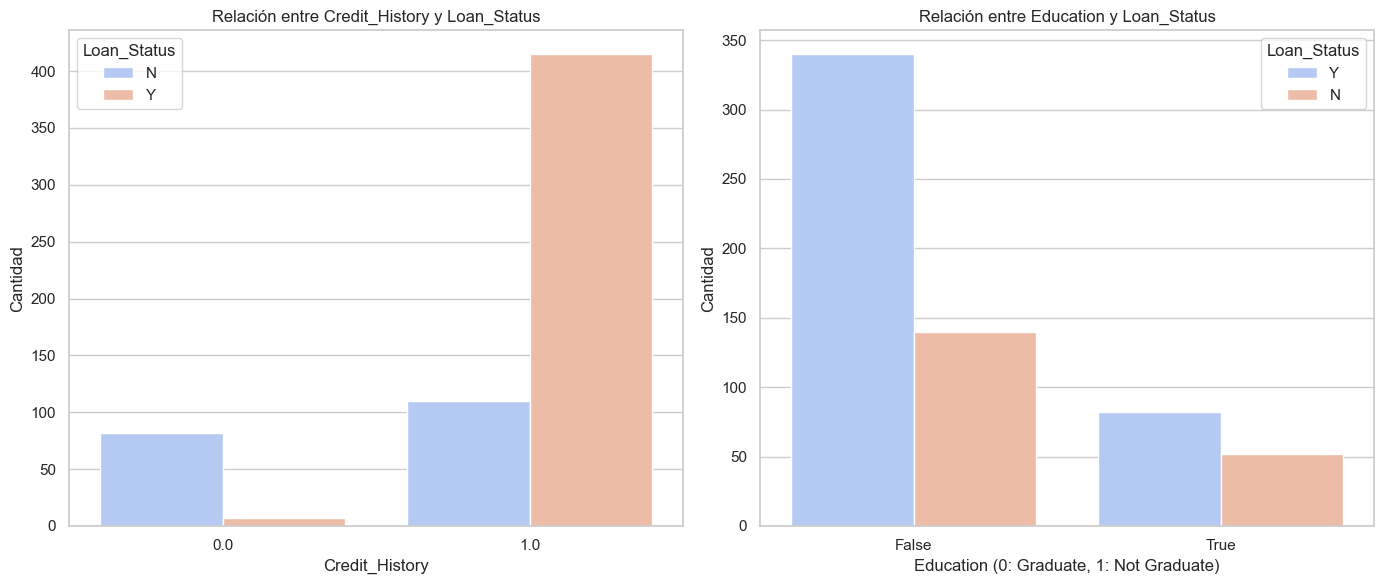

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Relación entre Credit_History y Loan_Status
sns.countplot(x='Credit_History', hue='Loan_Status', data=data_encoded, ax=ax[0], palette='coolwarm')
ax[0].set_title('Relación entre Credit_History y Loan_Status')
ax[0].set_xlabel('Credit_History')
ax[0].set_ylabel('Cantidad')
ax[0].legend(title='Loan_Status')

# Relación entre Education y Loan_Status
sns.countplot(x='Education_Not Graduate', hue='Loan_Status', data=data_encoded, ax=ax[1], palette='coolwarm')
ax[1].set_title('Relación entre Education y Loan_Status')
ax[1].set_xlabel('Education (0: Graduate, 1: Not Graduate)')
ax[1].set_ylabel('Cantidad')
ax[1].legend(title='Loan_Status')

plt.tight_layout()
plt.show()


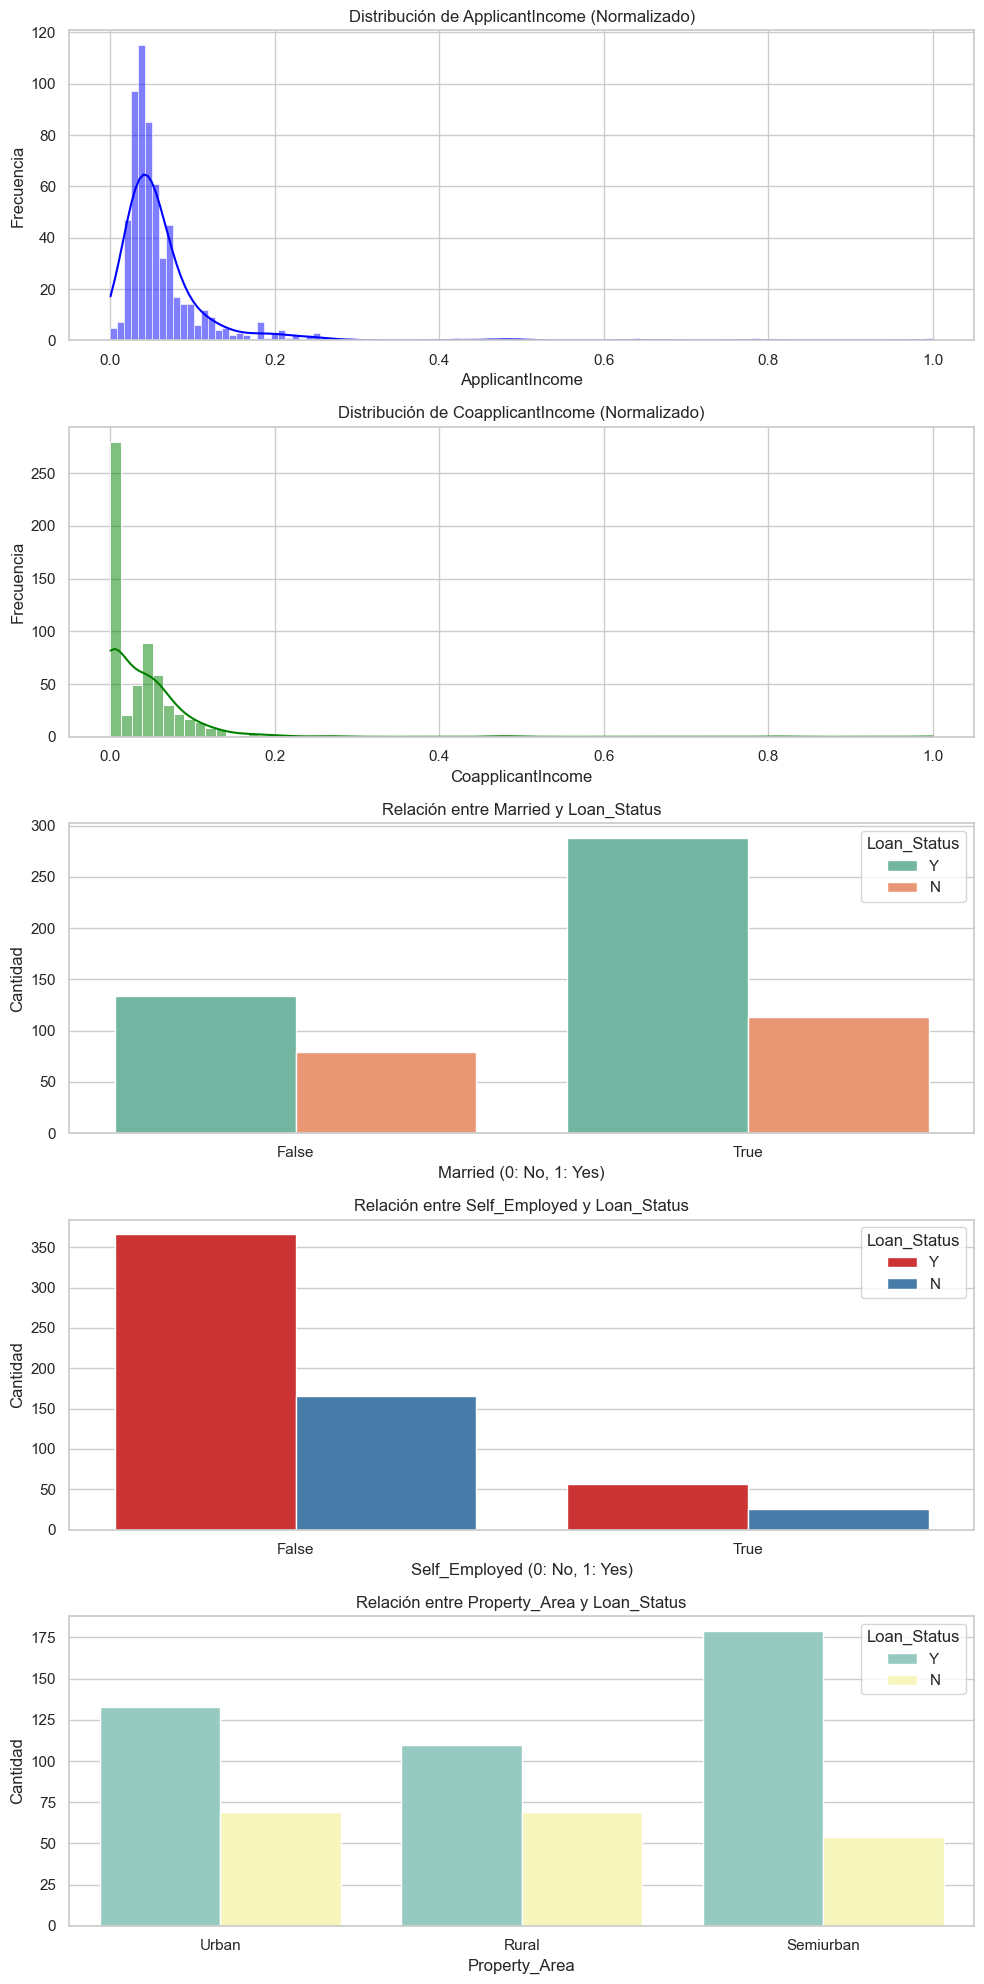

In [11]:
# Crear figura y ejes para los primeros cinco gráficos
fig, ax = plt.subplots(5, 1, figsize=(10, 20))

# 1. Distribución de ApplicantIncome
sns.histplot(data_encoded['ApplicantIncome'], kde=True, ax=ax[0], color='blue')
ax[0].set_title('Distribución de ApplicantIncome (Normalizado)')
ax[0].set_xlabel('ApplicantIncome')
ax[0].set_ylabel('Frecuencia')

# 2. Distribución de CoapplicantIncome
sns.histplot(data_encoded['CoapplicantIncome'], kde=True, ax=ax[1], color='green')
ax[1].set_title('Distribución de CoapplicantIncome (Normalizado)')
ax[1].set_xlabel('CoapplicantIncome')
ax[1].set_ylabel('Frecuencia')

# 3. Relación entre Married y Loan_Status
sns.countplot(x='Married_Yes', hue='Loan_Status', data=data_encoded, ax=ax[2], palette='Set2')
ax[2].set_title('Relación entre Married y Loan_Status')
ax[2].set_xlabel('Married (0: No, 1: Yes)')
ax[2].set_ylabel('Cantidad')
ax[2].legend(title='Loan_Status')

# 4. Relación entre Self_Employed y Loan_Status
sns.countplot(x='Self_Employed_Yes', hue='Loan_Status', data=data_encoded, ax=ax[3], palette='Set1')
ax[3].set_title('Relación entre Self_Employed y Loan_Status')
ax[3].set_xlabel('Self_Employed (0: No, 1: Yes)')
ax[3].set_ylabel('Cantidad')
ax[3].legend(title='Loan_Status')

# 5. Relación entre Property_Area y Loan_Status
sns.countplot(x=data['Property_Area'], hue='Loan_Status', data=data, ax=ax[4], palette='Set3')
ax[4].set_title('Relación entre Property_Area y Loan_Status')
ax[4].set_xlabel('Property_Area')
ax[4].set_ylabel('Cantidad')
ax[4].legend(title='Loan_Status')

plt.tight_layout()
plt.show()


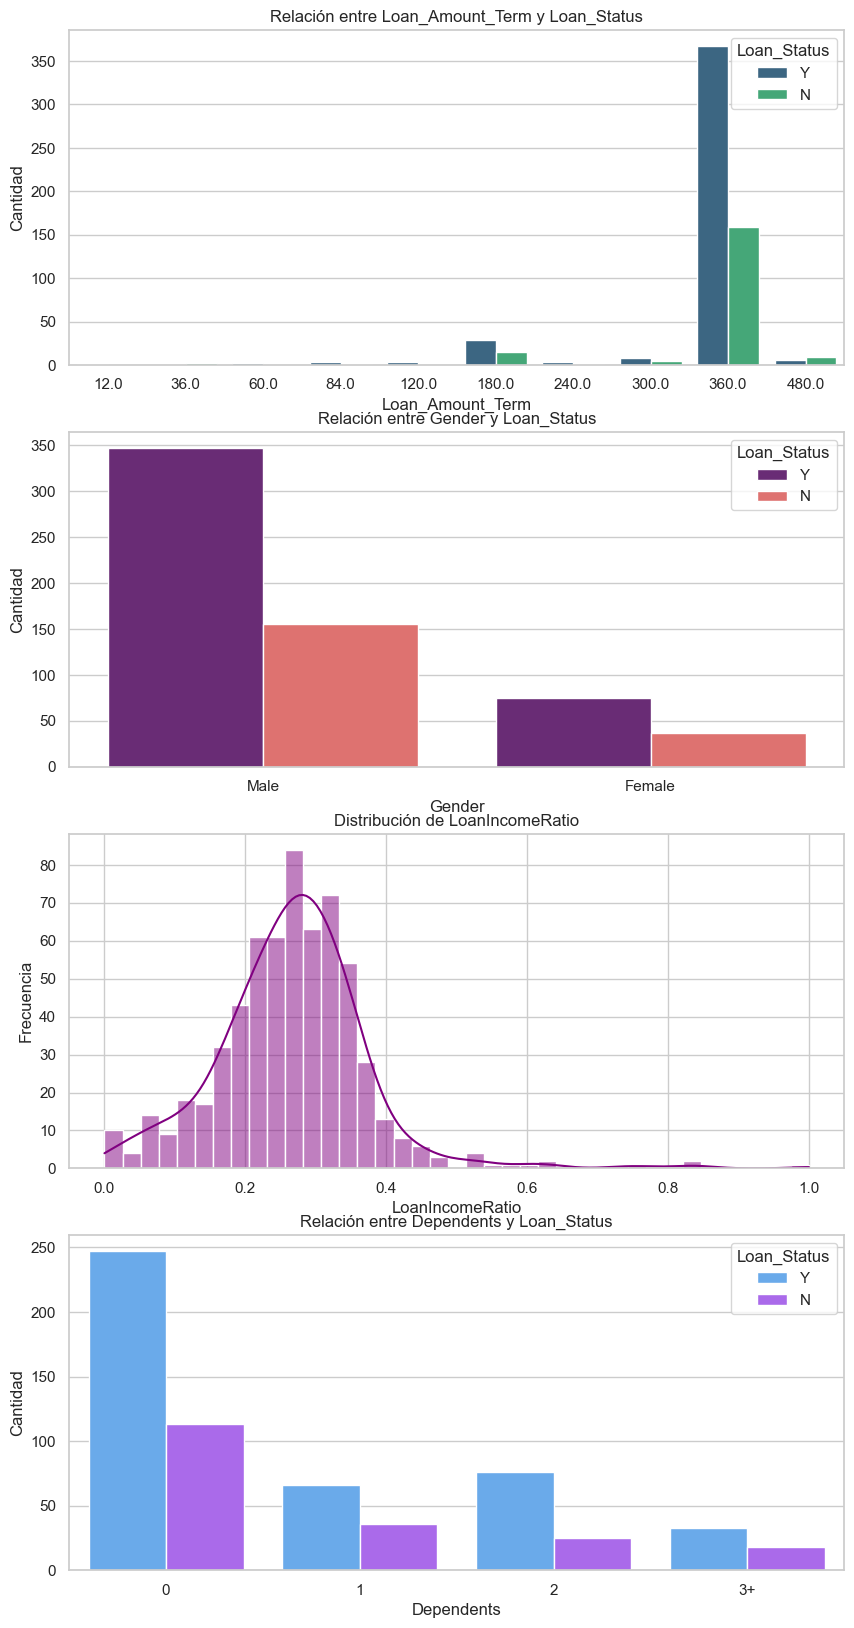

In [12]:
# Crear figura y ejes para los siguientes cinco gráficos
fig, ax = plt.subplots(4, 1, figsize=(10, 20))

# 6. Relación entre Loan_Amount_Term y Loan_Status
sns.countplot(x='Loan_Amount_Term', hue='Loan_Status', data=data, ax=ax[0], palette='viridis')
ax[0].set_title('Relación entre Loan_Amount_Term y Loan_Status')
ax[0].set_xlabel('Loan_Amount_Term')
ax[0].set_ylabel('Cantidad')
ax[0].legend(title='Loan_Status')

# 7. Relación entre Gender y Loan_Status
sns.countplot(x=data['Gender'], hue='Loan_Status', data=data, ax=ax[1], palette='magma')
ax[1].set_title('Relación entre Gender y Loan_Status')
ax[1].set_xlabel('Gender')
ax[1].set_ylabel('Cantidad')
ax[1].legend(title='Loan_Status')

# 8. Distribución de LoanIncomeRatio
sns.histplot(data_encoded['LoanIncomeRatio'], kde=True, ax=ax[2], color='purple')
ax[2].set_title('Distribución de LoanIncomeRatio')
ax[2].set_xlabel('LoanIncomeRatio')
ax[2].set_ylabel('Frecuencia')

# 9. Relación entre el número de dependientes (Dependents) y Loan_Status
sns.countplot(x='Dependents', hue='Loan_Status', data=data, ax=ax[3], palette='cool')
ax[3].set_title('Relación entre Dependents y Loan_Status')
ax[3].set_xlabel('Dependents')
ax[3].set_ylabel('Cantidad')
ax[3].legend(title='Loan_Status')

In [13]:
data.columns


Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [14]:
data_encoded.columns

Index(['Loan_ID', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Loan_Status', 'Gender_Male',
       'Married_Yes', 'Dependents_1', 'Dependents_2', 'Dependents_3+',
       'Education_Not Graduate', 'Self_Employed_Yes',
       'Property_Area_Semiurban', 'Property_Area_Urban', 'TotalIncome',
       'LoanIncomeRatio', 'IncomeLoanInteraction', 'LoanAmount_squared',
       'LoanAmount_cubed'],
      dtype='object')

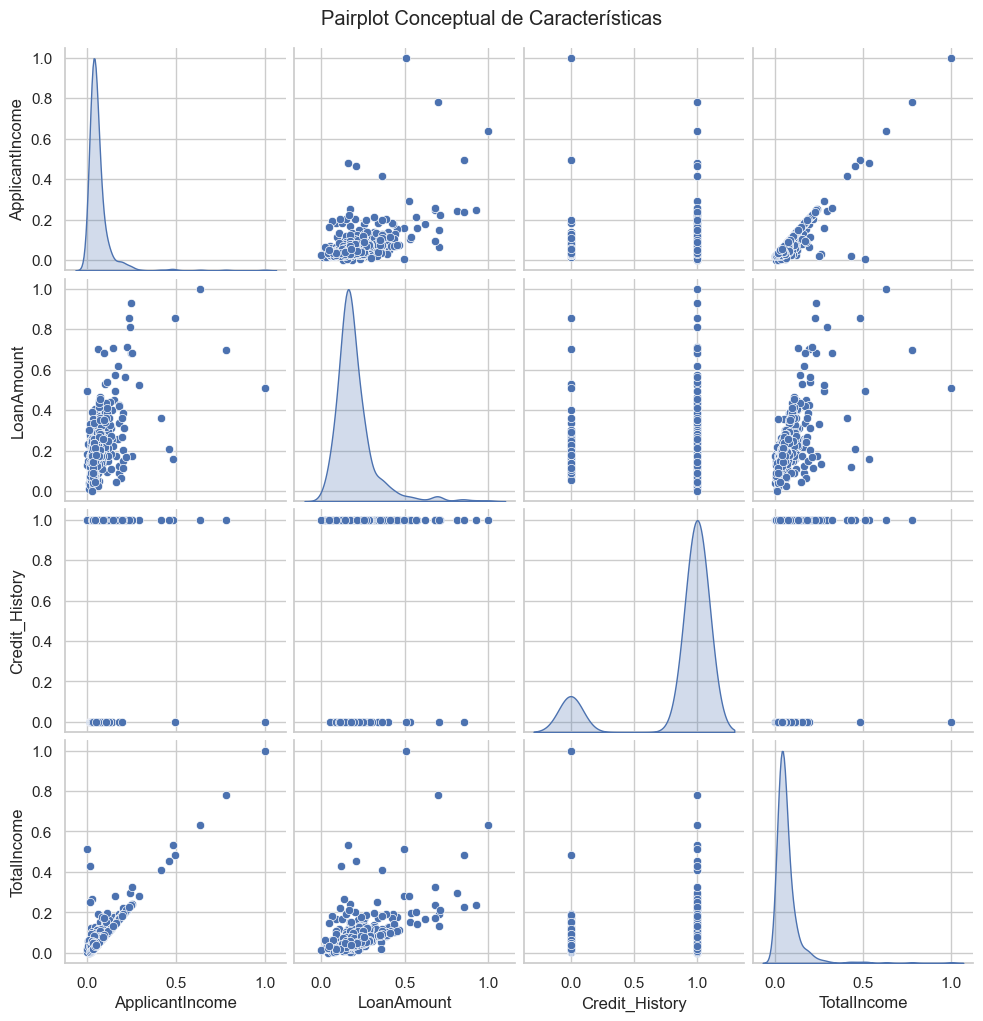

In [15]:
# Seleccionar un subconjunto más pequeño de características para el pairplot
features_subset_conceptual = ['ApplicantIncome', 'LoanAmount', 'Credit_History', 'TotalIncome']

# Generar pairplot para el subconjunto conceptual de características
sns.pairplot(data_encoded[features_subset_conceptual], diag_kind='kde')
plt.suptitle('Pairplot Conceptual de Características', y=1.02)  
plt.show()


In [16]:
data_encoded.to_csv("train.csv")

In [17]:
data_encoded.columns

Index(['Loan_ID', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Loan_Status', 'Gender_Male',
       'Married_Yes', 'Dependents_1', 'Dependents_2', 'Dependents_3+',
       'Education_Not Graduate', 'Self_Employed_Yes',
       'Property_Area_Semiurban', 'Property_Area_Urban', 'TotalIncome',
       'LoanIncomeRatio', 'IncomeLoanInteraction', 'LoanAmount_squared',
       'LoanAmount_cubed'],
      dtype='object')

## Machine Learning.

In [18]:
y = data_encoded['Loan_Status'].map({'Y': 1, 'N': 0})  
X = data_encoded.drop(['Loan_ID', 'Loan_Status'], axis=1)  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    object 
 2   Married            614 non-null    object 
 3   Dependents         614 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      614 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    float64
 10  Credit_History     614 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [20]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar los modelos
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier()
}

# Entrenar los modelos y evaluar su precisión
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} accuracy: {accuracy}")


LogisticRegression accuracy: 0.6422764227642277
SVM accuracy: 0.6504065040650406
KNN accuracy: 0.5284552845528455
DecisionTree accuracy: 0.7479674796747967


In [21]:
# Inicializar y entrenar el modelo de Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular la precisión
accuracy = accuracy_score(y_test, y_pred)
print(f"La precisión del modelo es: {accuracy}")


La precisión del modelo es: 0.7886178861788617


In [22]:
param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11)
}

random_search_rf = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=param_distributions, n_iter=100, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
random_search_rf.fit(X_train, y_train)

print("Mejores parámetros:", random_search_rf.best_params_)
print("Mejor precisión:", random_search_rf.best_score_)

best_rf_model = random_search_rf.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)
print(f"Random Forest (con mejores parámetros) precisión: {accuracy_score(y_test, y_pred_best_rf)}")


Mejores parámetros: {'max_depth': 19, 'min_samples_leaf': 6, 'min_samples_split': 9, 'n_estimators': 424}
Mejor precisión: 0.8247577819006391
Random Forest (con mejores parámetros) precisión: 0.7886178861788617


In [23]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [24]:
# Inicializar y entrenar el modelo XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba y evaluar
y_pred_xgb = xgb_model.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost accuracy: {accuracy_xgb}")


XGBoost accuracy: 0.7723577235772358


In [25]:
# Definir el espacio de parámetros con rangos para RandomizedSearchCV para XGBoost
param_distributions = {
    'n_estimators': randint(100, 500),  
    'learning_rate': uniform(0.01, 0.5),  
    'max_depth': randint(3, 10),  
    'subsample': uniform(0.5, 0.5),  
    'colsample_bytree': uniform(0.5, 0.5)  
}

# Crear RandomizedSearchCV para XGBoost
random_search = RandomizedSearchCV(estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
                                    param_distributions=param_distributions, n_iter=100, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# Mejores parámetros y mejor precisión para XGBoost
print("XGBoost - Mejores parámetros:", random_search.best_params_)
print("XGBoost - Mejor precisión:", random_search.best_score_)

# Entrenar de nuevo usando los mejores parámetros
best_xgb_model = XGBClassifier(**random_search.best_params_, use_label_encoder=False, eval_metric='logloss', random_state=42)
best_xgb_model.fit(X_train, y_train)
y_pred_best_xgb = best_xgb_model.predict(X_test)
accuracy_best_xgb = accuracy_score(y_test, y_pred_best_xgb)
print(f"XGBoost (con mejores parámetros) precisión: {accuracy_best_xgb}")


XGBoost - Mejores parámetros: {'colsample_bytree': 0.5580363202534582, 'learning_rate': 0.033001321010876376, 'max_depth': 3, 'n_estimators': 193, 'subsample': 0.9277302920055036}
XGBoost - Mejor precisión: 0.8226963512677798
XGBoost (con mejores parámetros) precisión: 0.7886178861788617


In [26]:
# Usando el mejor modelo encontrado por RandomizedSearchCV
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

from sklearn.metrics import accuracy_score
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")


Accuracy: 0.7886178861788617


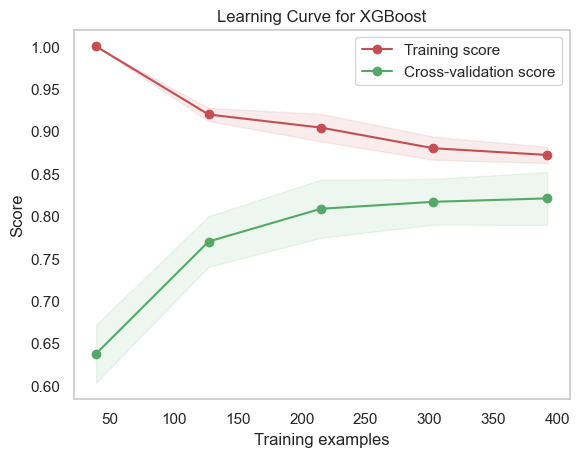

In [50]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Usando tu modelo XGBoost optimizado
plot_learning_curve(estimator=best_xgb_model, title="Learning Curve for XGBoost", X=X_train, y=y_train, cv=5, n_jobs=-1)
plt.show()


In [27]:
# Inicializar el modelo de Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)

# Entrenar el modelo con el conjunto de entrenamiento
gb_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_gb = gb_model.predict(X_test)

# Calcular y mostrar la precisión
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"Gradient Boosting accuracy: {accuracy_gb}")


Gradient Boosting accuracy: 0.7886178861788617


In [28]:
# Definir el espacio de parámetros para RandomizedSearchCV
param_distributions_gb = {
    'n_estimators': randint(100, 500),
    'learning_rate': [0.01, 0.1, 0.2, 0.5],
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10)
}

# Crear RandomizedSearchCV
random_search_gb = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_distributions=param_distributions_gb,
    n_iter=100,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

# Ejecutar RandomizedSearchCV
random_search_gb.fit(X_train, y_train)

# Mostrar los mejores parámetros y la mejor precisión
print("Mejores parámetros para Gradient Boosting:", random_search_gb.best_params_)
print("Mejor precisión con Gradient Boosting:", random_search_gb.best_score_)

# Evaluar el modelo con los mejores parámetros en el conjunto de prueba
best_gb_model = random_search_gb.best_estimator_
y_pred_best_gb = best_gb_model.predict(X_test)
accuracy_best_gb = accuracy_score(y_test, y_pred_best_gb)
print(f"Gradient Boosting (con mejores parámetros) precisión: {accuracy_best_gb}")


Mejores parámetros para Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 167}
Mejor precisión con Gradient Boosting: 0.8186971758400329
Gradient Boosting (con mejores parámetros) precisión: 0.7723577235772358


<module 'matplotlib.pyplot' from 'C:\\Users\\memol\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\matplotlib\\pyplot.py'>

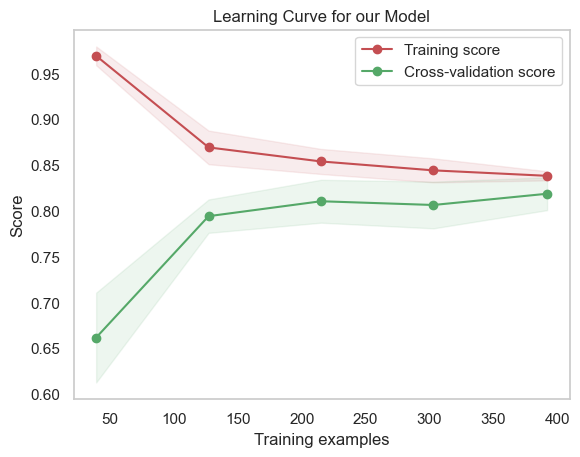

In [48]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Ejemplo de uso:
plot_learning_curve(estimator=best_gb_model, title="Learning Curve for our Model", X=X_train, y=y_train, cv=5)


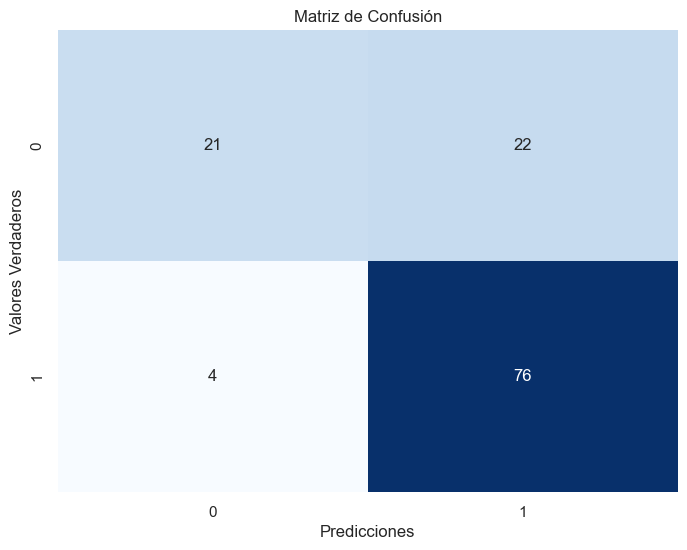

In [55]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

cm_df = pd.DataFrame(cm, index=model.classes_, columns=model.classes_)

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()


## Testeo

In [31]:
test_file_path = 'archive/test_Y3wMUE5_7gLdaTN.csv'
test_data = pd.read_csv(test_file_path)

# Mostrar las primeras filas del DataFrame de prueba para revisar la estructura y contenido de los datos
test_data.head()


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [32]:
missing_values = test_data.isnull().sum()

missing_values[missing_values > 0]


Gender              11
Dependents          10
Self_Employed       23
LoanAmount           5
Loan_Amount_Term     6
Credit_History      29
dtype: int64

In [33]:
categorical_columns = ['Gender', 'Married', 'Dependents', 'Self_Employed']
for column in categorical_columns:
    test_data[column].fillna(test_data[column].mode()[0], inplace=True)

numerical_columns = ['LoanAmount', 'Loan_Amount_Term', 'Credit_History']
for column in numerical_columns:
    test_data[column].fillna(test_data[column].median(), inplace=True)

# Verificar si aún quedan valores faltantes
remaining_missing_values = test_data.isnull().sum().sum()

remaining_missing_values


0

In [34]:
# Codificación de variables categóricas excepto 'Loan_Status' usando pd.get_dummies
test_data_encoded = pd.get_dummies(test_data, columns=['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area'], drop_first=True)

# Mostrar las primeras filas del DataFrame para revisar las nuevas columnas codificadas
test_data_encoded.head()


,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,LP001015,5720,0,110.0,360.0,1.0,True,True,False,False,False,False,False,False,True
1,LP001022,3076,1500,126.0,360.0,1.0,True,True,True,False,False,False,False,False,True
2,LP001031,5000,1800,208.0,360.0,1.0,True,True,False,True,False,False,False,False,True
3,LP001035,2340,2546,100.0,360.0,1.0,True,True,False,True,False,False,False,False,True
4,LP001051,3276,0,78.0,360.0,1.0,True,False,False,False,False,True,False,False,True


In [35]:
# Ingeniería de características: Creación de nuevas características
test_data_encoded['TotalIncome'] = test_data_encoded['ApplicantIncome'] + test_data_encoded['CoapplicantIncome']
test_data_encoded['LoanIncomeRatio'] = test_data_encoded['LoanAmount'] / test_data_encoded['TotalIncome']

# Creación de una característica de interacción entre TotalIncome y LoanAmount
test_data_encoded['IncomeLoanInteraction'] = test_data_encoded['TotalIncome'] * test_data_encoded['LoanAmount']

# Creación de características polinomiales para LoanAmount (al cuadrado y al cubo)
test_data_encoded['LoanAmount_squared'] = test_data_encoded['LoanAmount'] ** 2
test_data_encoded['LoanAmount_cubed'] = test_data_encoded['LoanAmount'] ** 3

# Seleccionar características numéricas para normalización (excluyendo las que ya están en escala binaria)
features_to_normalize = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'TotalIncome', 'LoanIncomeRatio']

scaler = MinMaxScaler()
test_data_encoded[features_to_normalize] = scaler.fit_transform(test_data_encoded[features_to_normalize])

# Mostrar las primeras filas para revisar los cambios realizados
test_data_encoded.head()


,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,TotalIncome,LoanIncomeRatio,IncomeLoanInteraction,LoanAmount_squared,LoanAmount_cubed
0,LP001015,0.078865,0.000000,0.157088,0.746835,1.0,True,True,False,False,False,False,False,False,True,0.055957,0.172625,629200.0,12100.0,1331000.0
1,LP001022,0.042411,0.062500,0.187739,0.746835,1.0,True,True,True,False,False,False,False,False,True,0.039791,0.255362,576576.0,15876.0,2000376.0
2,LP001031,0.068938,0.075000,0.344828,0.746835,1.0,True,True,False,True,False,False,False,False,True,0.071218,0.285783,1414400.0,43264.0,8998912.0
3,LP001035,0.032263,0.106083,0.137931,0.746835,1.0,True,True,False,True,False,False,False,False,True,0.044172,0.184938,488600.0,10000.0,1000000.0
4,LP001051,0.045168,0.000000,0.095785,0.746835,1.0,True,False,False,False,False,True,False,False,True,0.021422,0.218245,255528.0,6084.0,474552.0


In [36]:
test_data_encoded.columns

Index(['Loan_ID', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Gender_Male', 'Married_Yes',
       'Dependents_1', 'Dependents_2', 'Dependents_3+',
       'Education_Not Graduate', 'Self_Employed_Yes',
       'Property_Area_Semiurban', 'Property_Area_Urban', 'TotalIncome',
       'LoanIncomeRatio', 'IncomeLoanInteraction', 'LoanAmount_squared',
       'LoanAmount_cubed'],
      dtype='object')

In [37]:
# Primero, aplicamos pd.get_dummies al conjunto de prueba
X_test_prepared = pd.get_dummies(test_data_encoded.drop(['Loan_ID'], axis=1))

# Luego, aseguramos que X_test_prepared tenga las mismas columnas que X_train_prepared
# Añadimos columnas faltantes con 0s
missing_cols = set(X_train.columns) - set(X_test_prepared.columns)
for c in missing_cols:
    X_test_prepared[c] = 0

# Aseguramos el mismo orden de columnas
X_test_prepared = X_test_prepared[X_train.columns]

# Ahora, X_test_prepared está listo para ser utilizado para predicciones
y_pred_test = best_xgb_model.predict(X_test_prepared)


In [38]:
y_test

350    1
377    1
163    1
609    1
132    1
      ..
231    1
312    1
248    1
11     1
333    1
Name: Loan_Status, Length: 123, dtype: int64

In [39]:
# Realizar predicciones con el modelo XGBoost optimizado
y_pred_test = best_xgb_model.predict(X_test_prepared)

# Aquí, y_pred_test son tus predicciones para el conjunto de prueba
y_pred_test

array([1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,

In [42]:
y_pred_test_example = np.random.randint(2, size=test_data.shape[0])

# Crear el DataFrame de envío para visualización
submission_df = pd.DataFrame({
    "Loan_ID": test_data["Loan_ID"],
    "Loan_Status": y_pred_test_example
})

# Convertir predicciones numéricas a categorías ('Y' para 1, 'N' para 0)
submission_df["Loan_Status"] = submission_df["Loan_Status"].apply(lambda x: 'Y' if x == 1 else 'N')

# Mostrar el DataFrame creado
submission_df.head()


,Loan_ID,Loan_Status
0,LP001015,Y
1,LP001022,N
2,LP001031,N
3,LP001035,N
4,LP001051,Y


In [43]:
# Nuevamente usamos y_pred_test_example para la demostración
test_data_with_predictions = test_data.copy()
test_data_with_predictions["Loan_Status_Predicted"] = y_pred_test_example

# Convertir las predicciones numéricas a categorías ('Y' para 1, 'N' para 0)
test_data_with_predictions["Loan_Status_Predicted"] = test_data_with_predictions["Loan_Status_Predicted"].apply(lambda x: 'Y' if x == 1 else 'N')

# Mostrar el DataFrame con todas las columnas originales y la columna de predicciones añadida
test_data_with_predictions.head()


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status_Predicted
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban,Y
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban,N
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban,N
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,1.0,Urban,N
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban,Y


## Probabilidad de conceder préstamos.

In [ ]:
# Generar probabilidades de las clases (si tu modelo lo permite)
y_pred_prob = best_xgb_model.predict_proba(X_test_prepared)

# Crear un DataFrame con las probabilidades
prob_df = pd.DataFrame(y_pred_prob, columns=['Prob_Neg', 'Prob_Pos'])


In [ ]:
loan_ids = test_data_with_predictions['Loan_ID'].values

predictions_df = pd.DataFrame({
    "Loan_ID": loan_ids,
    "Prediction": y_pred_test,
    "Prob_Neg": prob_df['Prob_Neg'],
    "Prob_Pos": prob_df['Prob_Pos']
})

predictions_df.head()